I check whether two different state space representations of the basic dynamic factor model yield identical smoothed states, namely:

- the standard representation with the state vector $x_t = [f_t, u_{1,t} \dots u_{n,t}]$
- a representation with transformed observations and state vector $x_t = [f_t, f_{t-1}]$ that can be obtained as follows

$y_{i,t} - \psi_i y_{i, t-1} = (1-\psi_i)\mu_i + \lambda_i f_t - \lambda\psi_i f_{t-1} + w_{i,t}$

**TODO**: this is a problem regarding initialization!

In [1]:
using Distributions
using Gadfly

In [2]:
include("../src/ssm.jl");

In [3]:
type DFM
    μ::Array{Float64,1}
    λ::Array{Float64,1}
    ϕ::Float64
    σ2v::Float64
    ψ::Array{Float64,1}
    σ2w::Array{Float64,1}
end


function get_state_space_representation(dfm::DFM)
    n = length(dfm.λ)
    # better: n = dfm.n
    μ = dfm.μ
    A = diagm([dfm.ϕ, dfm.ψ...])
    B = [dfm.λ eye(n)]
    R = eye(n+1)

    Σ = diagm([dfm.σ2v, dfm.σ2w...])

    return StateSpaceModel(μ, A, B, Σ, R)

end


function get_Kalman_filter_initialization(dfm::DFM)

    n = length(dfm.λ)
    # better: n = dfm.n

    xf1  = zeros(n+1)
    Σxf1 = diagm([dfm.σ2v/(1-dfm.ϕ^2), dfm.σ2w./(1-dfm.ψ.^2)...])

    return xf1, Σxf1

end

get_Kalman_filter_initialization (generic function with 1 method)

In [4]:
type StateSpaceModel2
    μ
    A
    B
    Σ
    R
    W
end

function get_state_space_representation2(dfm::DFM)
    n = length(dfm.λ)
    # better: n = dfm.n
    μ = (1-dfm.ψ).*dfm.μ
    A = [dfm.ϕ 0.; 1. 0]
    B = [dfm.λ -dfm.ψ.*dfm.λ]
    R = [1.; 0.]

    Σ = diagm([dfm.σ2v])
    
    W = diagm(dfm.σ2w)

    return StateSpaceModel2(μ, A, B, Σ, R, W)

end

function get_Kalman_filter_initialization2(dfm::DFM)

    n = length(dfm.λ)
    # better: n = dfm.n

    xf1  = zeros(2)
    Σxf1 = dfm.σ2v/(1-dfm.ϕ^2) * [1. ϕ; ϕ 1.]

    return xf1, Σxf1

end

function fast_state_smoothing(
    y::Array{Float64,2},
    ssm::StateSpaceModel2,
    xf1::Array{Float64,1},
    Σxf1::Array{Float64,2},
    )

    μ, A, B, Σ, R, W = ssm.μ, ssm.A, ssm.B, ssm.Σ, ssm.R, ssm.W
    V = R*Σ*R'

    T, _   = size(y)
    n, k = size(B)

    xft  = xf1
    Σxft = Σxf1

    q = zeros(T, k)
    L = zeros(T, k, k)

    for t=1:T

        yt = y[t,:]
        St = get_selection_matrix(yt)
        yt = Vector(St*sparse(yt)) # otherwise NaN because 0 * NaN = NaN

        Bt  = St*B
        μt  = St*μ
        Δyt = yt-μt-Bt*xft
        Ft  = Bt*Σxft*Bt' + St*W*St'
        Mt  = Bt'/Ft
        Kt  = A*Σxft*Mt

        Lt  = A-Kt*Bt
        qt = Mt*Δyt

        L[t,:,:] = Lt
        q[t,:] = qt

        xft  = A*xft + Kt*Δyt
        Σxft = A*Σxft*Lt'+ V

    end

    r = zeros(T+1, k) # index shifted by +1 !
    # i.e. also r[T+1,:] = 0

    for t=T:-1:1
        Lt = L[t,:,:]
        r[t,:] = q[t,:] + Lt'*r[t+1,:]
    end

    xs      = zeros(T, k)
    xs[1,:] = xf1 + Σxf1*r[1,:]

    for t=1:T-1
        xs[t+1,:] = A*xs[t,:] + V*r[t+1,:]
    end

    return xs

end

fast_state_smoothing (generic function with 2 methods)

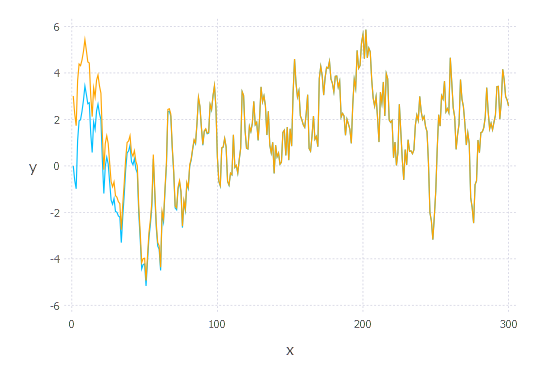

In [5]:
n = 10

μ = zeros(n)
λ = ones(n)
ϕ = 0.95
σ2v = 1.
ψ = 0.95*ones(n)
σ2w = ones(n)

dfm = DFM(μ, λ, ϕ, σ2v, ψ, σ2w)
ssm = get_state_space_representation(dfm)
xf1, Σxf1 = get_Kalman_filter_initialization(dfm)

T = 300
x, y = simulate(ssm, xf1, Σxf1, T)

xs = fast_state_smoothing(y, ssm, xf1, Σxf1);

ssm2 = get_state_space_representation2(dfm)
xf12, Σxf12 = get_Kalman_filter_initialization2(dfm)

y_transf = y[2:T,:]-dfm.ψ'.*y[1:T-1,:]
xs2 = fast_state_smoothing(y_transf, ssm2, xf12, Σxf12)

fs1 = xs[:,1]
fs2 = [xs2[1,2], xs2[:,1]...]

plot(
#   layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    layer(x=1:T, y=fs1, Geom.line, Theme(default_color="orange")),
    layer(x=1:T, y=fs2, Geom.line),
    )

In [6]:
fs2-fs1

300-element Array{Float64,1}:
 -3.00771   
 -2.85733   
 -2.71446   
 -2.57874   
 -2.4498    
 -2.32731   
 -2.21095   
 -2.1004    
 -1.99538   
 -1.89561   
 -1.80083   
 -1.71079   
 -1.62525   
  ⋮         
 -1.15514e-6
 -1.09738e-6
 -1.04251e-6
 -9.90389e-7
 -9.40869e-7
 -8.93826e-7
 -8.49135e-7
 -8.06678e-7
 -7.66344e-7
 -7.28027e-7
 -6.91626e-7
 -6.57044e-7